In this notebook we analyse the stabilisation of the helical state propagating in the `x`-direction of the Co8Zn9Mn3 film by means of a field sweep (field decreasing), with the field applied along the sample thickness (`y`-direction). The initial state are two proximate skyrmion strings at the centre of the film.

To obtain a helix in the `x`-direction, an uniaxial anisotropy with an easy plane in the `yz`-plane (hard `x`-axis) is required. These simulations show the field sweep for different magnitudes of the uniaxial anisotropy in order to find the threshold value where the helix propagating in the `x`-direction is formed. We find that this value is Ku = -4 kJ/m^3.

# Imports

In [1]:
import numpy as np
import oommfpy as op
import matplotlib.pyplot as plt
from pathlib import Path
import re

import matplotlib.patheffects as PathEffects

import collections

# Parameters

In [2]:
Ms = 4.60545e5
A = 7.875e-12
# A = 6e-12
D = 0.6e-3
LD = 4 * np.pi * A / D

# Anisotropies

Print the first lines of the mumax table for one of the simulations:

In [3]:
!head ../sims/mumax3/two_tubes_field-sweep_Co8Zn9Mn3_anisotropy/two_tubes_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_field-sweep.out/table.txt

# t (s)	mx ()	my ()	mz ()	E_total (J)	B_extx (T)	B_exty (T)	B_extz (T)	E_exch (J)	maxTorque (T)	Ku1 (J/m3)
0	0	-0.9782012	0.09666031	-3.6737903e-15	0	-0.09999986	0	-2.0463411e-16	2.5857935	-1000
5.007309341400866e-10	3.4748522e-05	-0.6999856	0.0006971492	-6.3564567e-15	0	-0.09999986	0	-2.1325704e-15	0.044932634	-1000
1.0014175286761911e-09	4.373308e-05	-0.68753195	0.001002617	-6.400147e-15	0	-0.09999987	0	-2.211393e-15	0.08641147	-1000
1.5013862257721418e-09	-0.0011689889	-0.6684988	0.0015437015	-6.47287e-15	0	-0.09999987	0	-2.3434109e-15	0.010707326	-1000
2.0005945164888994e-09	-0.0016994794	-0.64768183	0.0017396482	-6.5175624e-15	0	-0.09999986	0	-2.4601744e-15	0.040100984	-1000
2.500508723477015e-09	-0.0018603725	-0.6387238	0.0017577981	-6.527979e-15	0	-0.09999987	0	-2.5039518e-15	0.0052238326	-1000
3e-09	-0.0017955002	-0.63645035	0.001706575	-6.5300917e-15	0	-0.09999987	0	-2.5146238e-15	0.004638049	-1000
3e-09	-0.0039411797	-0.63451403	0.0014758247	-6.5368163e-15	0	-0.09999987	0	-2.

Create a data structure to store the magetic parameters from a simulation:

In [4]:
MagAvData = collections.namedtuple('MagAvData', ['Ku', 'By', 'mz_average', 'E'])

## Field relaxation: finding transitions

In [16]:
# Anisotropy values for the simulation file names:
ANIS_VALUES = [f'-{k:05d}' for k in range(1, 9)]
print(ANIS_VALUES)

['-00001', '-00002', '-00003', '-00004', '-00005', '-00006', '-00007', '-00008']


In [6]:
# Save all the simulation results in this list:
mz_averages = []

# BASEDIR = Path('../sims/mumax3/two_tubes_field-sweep_Co8Zn9Mn3_anisotropy/two_tubes_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_field-sweep.out/')
BASEDIR = Path('../sims/mumax3/two_tubes_field-sweep_Co8Zn9Mn3_anisotropy/'
               'two_tubes_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_field-sweep_REFINED.out/')
# print(list(BASEDIR.glob('*.ovf')))
# Simulation data table:
tab = np.loadtxt(BASEDIR / 'table.txt')

for ku in ANIS_VALUES:  # kJ/m^3
    print(f'ku = {ku}')
    for by in np.arange(-100, -9, 5):      # mT

        FILE = BASEDIR / f'm_Ku_x-axis_{ku}_kJm3_By_-{abs(by):05d}_mT.ovf'
        # if not FILE.exists():
        #     continue

        # Load data using OOMMFPy:
        data = op.MagnetisationData(FILE)
        data.generate_coordinates()
        data.generate_field()
        mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)
        
        # Perform average of mz across thickness:
        mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
        for z_idx in range(mz_3d.shape[0]):
            mz_av += mz_3d[z_idx, :, :]

        mz_av /= mz_3d.shape[0]
        
        # Energy -> make a numpy mask to extract the energy from the Table
        f = np.logical_and.reduce((tab[:, -2] < 1e-5,                      # Torque
                                   tab[:, -1] == float(ku) * 1000,         # Anisotropy
                                   np.abs(tab[:, 6] - (by * 1e-3)) < 1e-4) # Field
                                  )
        energy = tab[:, 4][f]

        # Save the parameters and mz average in the data structure:
        mz_averages.append(MagAvData(Ku=ku, By=by, mz_average=mz_av, E=energy))
        
        # mz_average[by] = mz_av

ku = -00001
ku = -00002
ku = -00003
ku = -00004
ku = -00005
ku = -00006
ku = -00007
ku = -00008


In [7]:
mz_averages[:2]

[MagAvData(Ku='-00001', By=-100, mz_average=array([[ 0.125944  , -0.03010813, -0.17130374, ...,  0.1025904 ,
         -0.03540176, -0.1852064 ],
        [ 0.2713931 ,  0.11523847, -0.02916279, ..., -0.0382068 ,
         -0.17912134, -0.329077  ],
        [ 0.39390054,  0.24147259,  0.0974507 , ..., -0.15767345,
         -0.29809595, -0.44449183],
        ...,
        [ 0.39288139,  0.2403625 ,  0.09624405, ..., -0.15653841,
         -0.29666781, -0.44306819],
        [ 0.26977742,  0.1134789 , -0.03102983, ..., -0.03734878,
         -0.17794963, -0.32784824],
        [ 0.1240035 , -0.03220996, -0.17350314, ...,  0.10326954,
         -0.03441996, -0.18414391]]), E=array([-6.5368154e-15])),
 MagAvData(Ku='-00001', By=-95, mz_average=array([[ 0.11465425, -0.04354869, -0.18770887, ...,  0.10973856,
         -0.03247684, -0.18459857],
        [ 0.26225772,  0.10407771, -0.04364576, ..., -0.03124641,
         -0.17665996, -0.32879949],
        [ 0.38876219,  0.23481249,  0.08747791, ..., -0.

In [8]:
[[d.By, d.E[0]] for d in mz_averages if d.Ku == '-00010']

[]

Here we print the total energy of every simulation (different anisotropies) as a function of the applied field (from the field sweep):

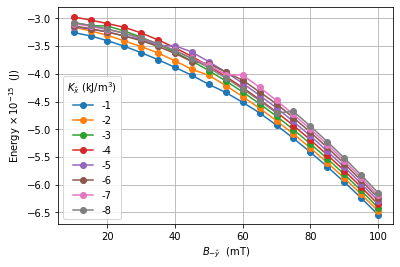

In [9]:
state_pick = [[d.By, d.E[0]] for d in mz_averages if d.Ku == '-00001']
state_pick = np.array(state_pick, dtype=np.float64)

f, ax = plt.subplots()

for ku in ANIS_VALUES:
    state_pick = [[abs(d.By), d.E[0]] for d in mz_averages if d.Ku == ku]
    state_pick = np.array(state_pick, dtype=np.float64)
    ax.plot(state_pick[:, 0], state_pick[:, 1] * 1e15, 'o-', label=f'{float(ku):.0f}')

ax.legend(title=r'$K_{\hat{x}}$' + ' (kJ/m' + r'$^{3})$')
ax.set_ylabel('Energy ' + r'$\times \, 10^{-15}$ ' + ' (J)')
ax.set_xlabel(r'$B_{-\hat{y}}$' + '  (mT)')
ax.grid()

# plt.yscale('log')

plt.savefig('two_tubes_field-sweep_anisotropy_x-hard-axis_energies.pdf', bbox_inches='tight')
plt.show()

In [28]:
# PLOTDIR_FS = PLOTDIR / f'two_tubes_field-sweep_DOWN'
# PLOTDIR_FS.mkdir(exist_ok=True)
# for by in np.arange(-100, -4, 5):
#     np.savetxt(PLOTDIR_FS / f'm_field-sweep_By_{by:06d}.txt', mz_average_down[by])

## Plot of averages

In [10]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [11]:
PLOTDIR = Path('two_tubes_to_helical_anisotropies')
PLOTDIR.mkdir(exist_ok=True)

Ku(x) : -1000.0 J/m^3


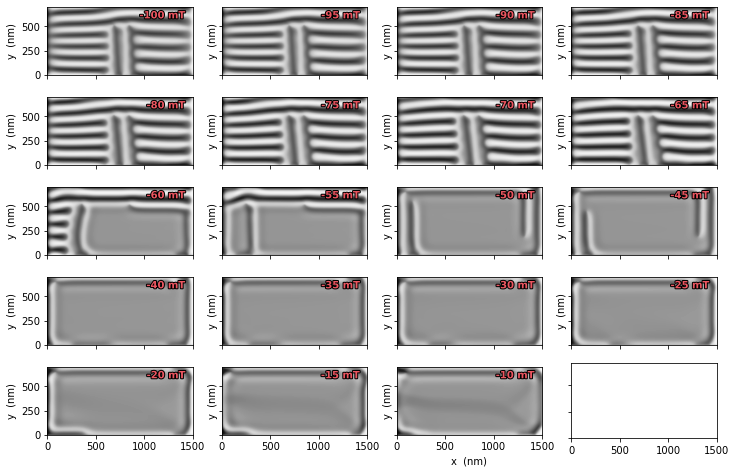

Ku(x) : -2000.0 J/m^3


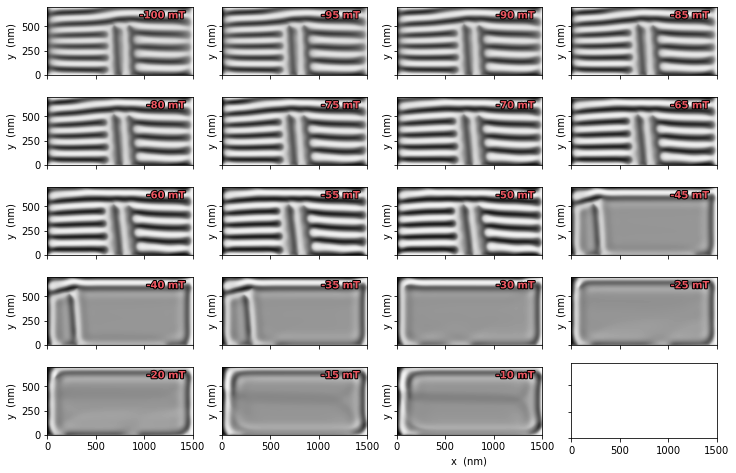

Ku(x) : -3000.0 J/m^3


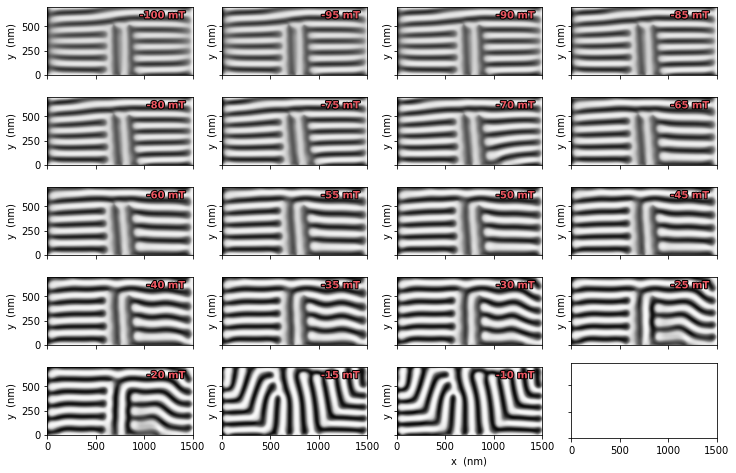

Ku(x) : -4000.0 J/m^3


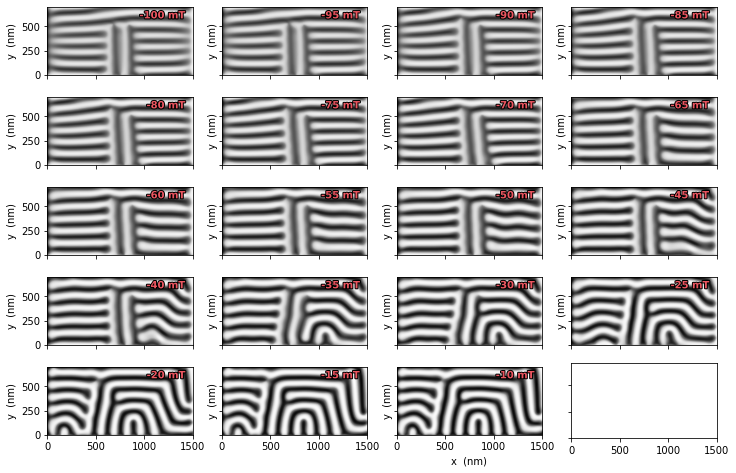

Ku(x) : -5000.0 J/m^3


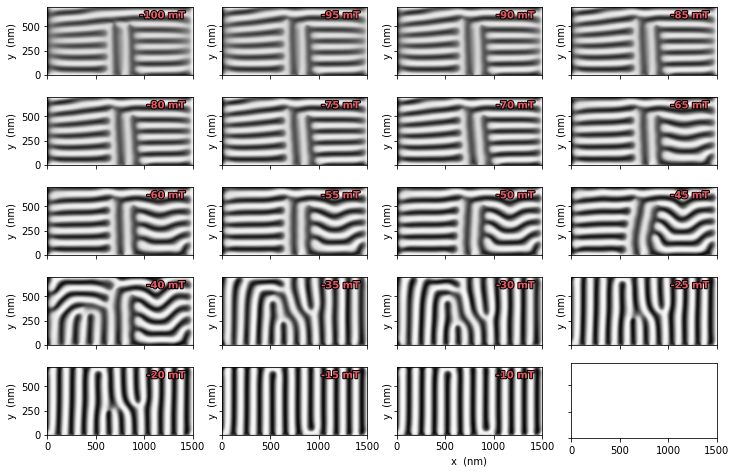

Ku(x) : -6000.0 J/m^3


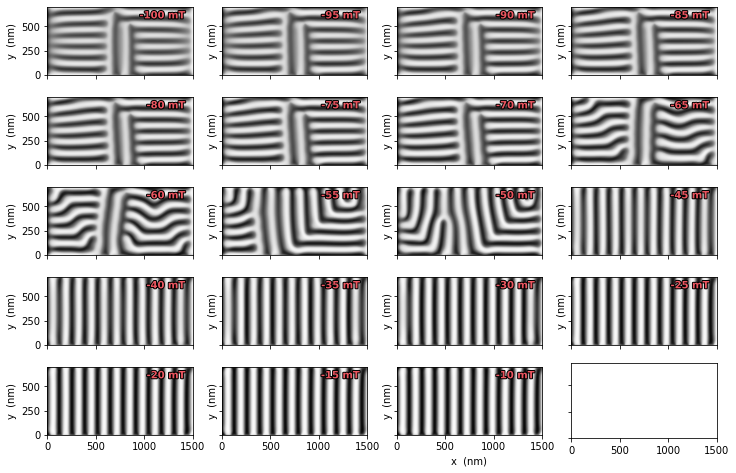

Ku(x) : -7000.0 J/m^3


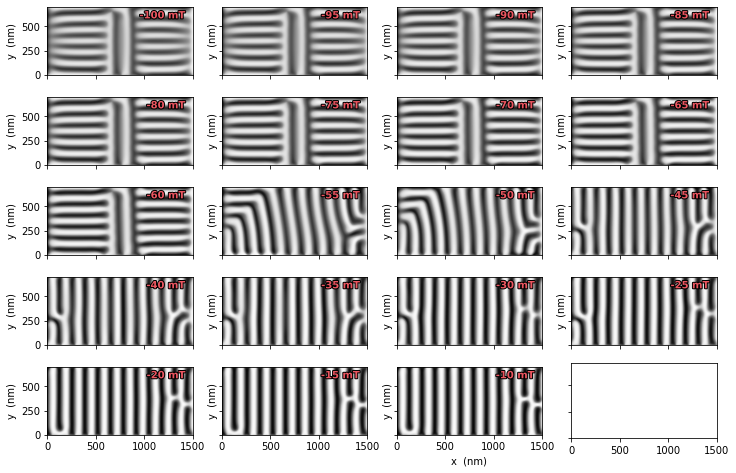

Ku(x) : -8000.0 J/m^3


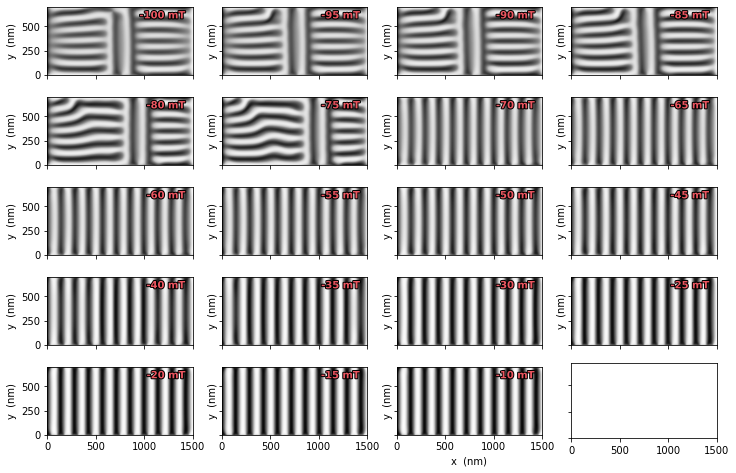

In [15]:
for ku in ANIS_VALUES:
    
    print(f'Ku(x) : {float(ku) * 1000} J/m^3')

    f, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5, sharex=True, sharey=True)

    mz_av_anis_pick = {d.By: d.mz_average for d in mz_averages if d.Ku == ku}

    for b, by in enumerate(np.arange(-100, -9, 5)):

        ax = axs.flat[b]
        ax.imshow(mz_av_anis_pick[by], cmap='Greys', **im_tubes_args)
        # axs[b][p].set_xlabel('x  (nm)')
        # axs[b][p].set_ylabel('y  (nm)')
        # axs[b][p].set_title(f'Field: {by} mT')

        t = ax.text(0.95, 0.95, f'{by} mT', ha='right', va='top',
                    transform=ax.transAxes, 
                    rotation=0, color='#EB5660', fontweight='bold')

        t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
        ax.set_ylabel('y  (nm)')

        if b >= 18:
            ax.set_xlabel('x  (nm)')

    # plt.tight_layout()
    plt.savefig(PLOTDIR / f'mz_average_Ku_{ku}_kJm3_field-relax.png', dpi=200, bbox_inches='tight')
    plt.show()

In [11]:
ANIS_VALUES

['-00001',
 '-00002',
 '-00003',
 '-00004',
 '-00005',
 '-00006',
 '-00007',
 '-00008']

In [18]:
# for ku in ANIS_VALUES:
for ku in ['-00004']:
    mz_av_anis_pick = {str(d.By): d.mz_average for d in mz_averages if d.Ku == ku}
    np.savez(PLOTDIR / f'mz_averages_Bzs_ku_{ku}', **mz_av_anis_pick)

In [20]:
data = np.load(PLOTDIR / f'mz_averages_Bzs_ku_{ku}.npz')

In [24]:
for k in data.keys():
    print(k)

-100
-95
-90
-85
-80
-75
-70
-65
-60
-55
-50
-45
-40
-35
-30
-25
-20
-15
-10


In [39]:
for k in mz_average.keys():
    print(mz_average[k].min())

-0.994432883707798
-0.996715784129429
-0.995755128110595
-0.9968941681705752
-0.9982216219747885
-0.9990169223654657
-0.9974449539164925
-0.9992441199369269
-0.9984544562788609
-0.9999704467511679
-0.9992679767915172
-0.9988611400508394


# Results for Ku = -4000 J / m^3

## Field relaxation: tubes separated 20% Lx

In [33]:
import re

In [34]:
MagAvDataSep = collections.namedtuple('MagAvData', ['Ku', 'By', 'mz_average', 'E', 'sweep'])

In [35]:
ANIS_VALUES = [f'-{k:05d}' for k in [4]]

In [55]:
mz_averages_sep = []

BASEDIR_UP = Path('../sims/mumax3/two_tubes_separated_field-sweep_Co8Zn9Mn3_anisotropy/'
                  'two_tubes_sep20pLx_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_4kJm3_field-sweep_UP.out')

BASEDIR_DOWN = Path('../sims/mumax3/two_tubes_separated_field-sweep_Co8Zn9Mn3_anisotropy/'
                    'two_tubes_sep20pLx_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_4kJm3_field-sweep_DOWN.out')

OVFS = list(BASEDIR_UP.glob('./*.ovf')) + list(BASEDIR_DOWN.glob('./*.ovf'))

# print(list(BASEDIR.glob('*.ovf')))
# Simulation data table:
tab_UP = np.loadtxt(BASEDIR_UP / 'table.txt')
tab_DOWN = np.loadtxt(BASEDIR_DOWN / 'table.txt')

for ku in ANIS_VALUES:  # kJ/m^3
    print(f'ku = {ku}')
    
    for FILE in OVFS:      # mT
        
        # print(FILE.name)
        by = int(re.search(r'(?<=By_)[-0-9]+(?=_)', FILE.name).group(0))
        
        sweep = 'up' if abs(by) >= 100 else 'down'
        if sweep == 'up':
            tab = tab_UP
        else:
            tab = tab_DOWN

        # FILE = BASEDIR / f'm_Ku_x-axis_{ku}_kJm3_By_-{abs(by):05d}_mT.ovf'
        # if not FILE.exists():
        #     continue

        data = op.MagnetisationData(FILE)
        data.generate_coordinates()
        data.generate_field()
        mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

        mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
        for z_idx in range(mz_3d.shape[0]):
            mz_av += mz_3d[z_idx, :, :]

        mz_av /= mz_3d.shape[0]
        
        # Energy -> make a numpy mask to extract the energy from the Table
        f = np.logical_and.reduce((tab[:, -2] < 1e-5,                      # Torque
                                   tab[:, -1] == float(ku) * 1000,         # Anisotropy
                                   np.abs(tab[:, 6] - (by * 1e-3)) < 1e-4) # Field
                                  )
        energy = tab[:, 4][f]

        mz_averages_sep.append(MagAvDataSep(Ku=ku, By=by, mz_average=mz_av, E=energy, sweep=sweep))
        
        # mz_average[by] = mz_av

ku = -00004


In [69]:
mz_averages_sep[0]

MagAvData(Ku='-00004', By=-100, mz_average=array([[ 0.17550188,  0.02258596, -0.11798271, ...,  0.11557815,
        -0.02439722, -0.17685932],
       [ 0.31841843,  0.1653912 ,  0.02178627, ..., -0.02397585,
        -0.16695795, -0.31955769],
       [ 0.43474646,  0.28544177,  0.142403  , ..., -0.14400214,
        -0.28644523, -0.43540268],
       ...,
       [ 0.4358038 ,  0.28695638,  0.14466801, ..., -0.1437172 ,
        -0.2866329 , -0.43577722],
       [ 0.32018757,  0.16773425,  0.02492505, ..., -0.02314385,
        -0.16662962, -0.31950177],
       [ 0.17760106,  0.02529953, -0.1145047 , ...,  0.11666935,
        -0.02378971, -0.17655412]]), E=array([-6.3437508e-15]), sweep='up')

In [57]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [58]:
PLOTDIR = Path('two_tubes_separated_to_helical_anisotropies')
PLOTDIR.mkdir(exist_ok=True)

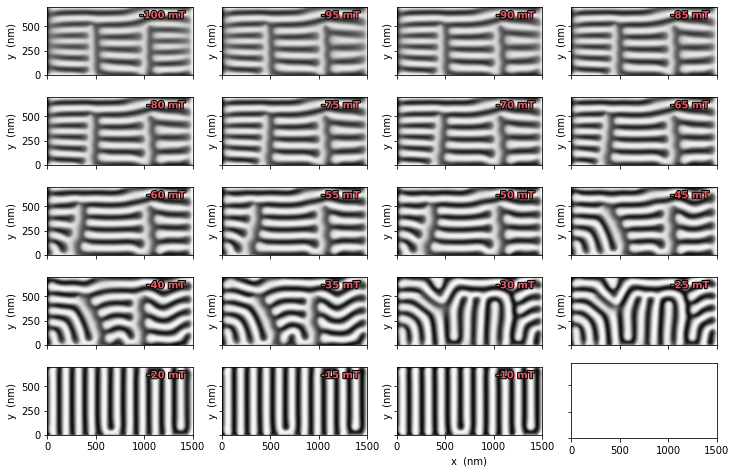

In [81]:
for ku in ANIS_VALUES:

    f, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5, sharex=True, sharey=True)

    mz_av_anis_pick = {str(d.By): d.mz_average for d in mz_averages_sep if d.Ku == ku and d.sweep == 'down'}
    mz_av_anis_pick['-100'] = [d.mz_average for d in mz_averages_sep if 
                               d.By == -100 and d.Ku == ku and d.sweep == 'up'][0]
    
    # Save this data
    np.savez(PLOTDIR / f'mz_averages_Bzs_ku_{ku}_SWEEP-DOWN', **mz_av_anis_pick)

    for b, by in enumerate(np.arange(-100, -9, 5)):

        ax = axs.flat[b]
        ax.imshow(mz_av_anis_pick[str(by)], cmap='Greys', **im_tubes_args)
        # axs[b][p].set_xlabel('x  (nm)')
        # axs[b][p].set_ylabel('y  (nm)')
        # axs[b][p].set_title(f'Field: {by} mT')

        t = ax.text(0.95, 0.95, f'{by} mT', ha='right', va='top',
                    transform=ax.transAxes, 
                    rotation=0, color='#EB5660', fontweight='bold')

        t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
        ax.set_ylabel('y  (nm)')

        if b >= 18:
            ax.set_xlabel('x  (nm)')

    # plt.tight_layout()
    plt.savefig(PLOTDIR / f'mz_average_Ku_{ku}_kJm3_field-relax_SWEEP_DOWN.png', dpi=200, bbox_inches='tight')
    plt.show()

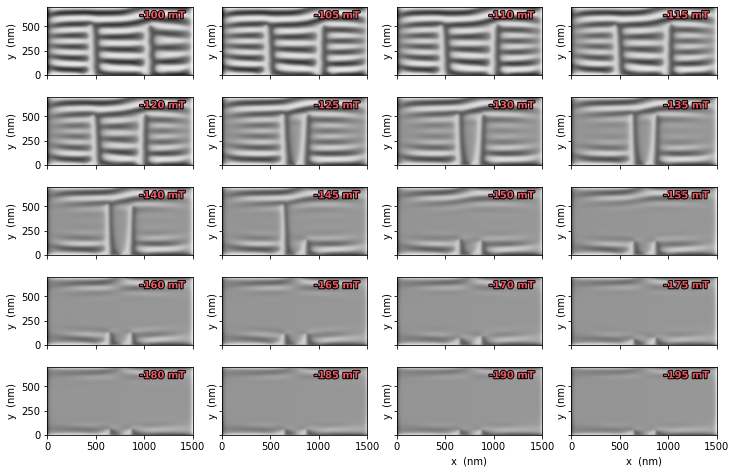

In [82]:
for ku in ANIS_VALUES:

    f, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5, sharex=True, sharey=True)

    mz_av_anis_pick = {str(d.By): d.mz_average for d in mz_averages_sep 
                       if d.Ku == ku and d.sweep == 'up'}
    
     # Save this data
    np.savez(PLOTDIR / f'mz_averages_Bzs_ku_{ku}_SWEEP-UP', **mz_av_anis_pick)

    for b, by in enumerate(np.arange(-100, -200, -5)):

        ax = axs.flat[b]
        ax.imshow(mz_av_anis_pick[str(by)], cmap='Greys', **im_tubes_args)
        # axs[b][p].set_xlabel('x  (nm)')
        # axs[b][p].set_ylabel('y  (nm)')
        # axs[b][p].set_title(f'Field: {by} mT')

        t = ax.text(0.95, 0.95, f'{by} mT', ha='right', va='top',
                    transform=ax.transAxes, 
                    rotation=0, color='#EB5660', fontweight='bold')

        t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
        ax.set_ylabel('y  (nm)')

        if b >= 18:
            ax.set_xlabel('x  (nm)')

    # plt.tight_layout()
    plt.savefig(PLOTDIR / f'mz_average_Ku_{ku}_kJm3_field-relax_SWEEP_UP.png', dpi=200, bbox_inches='tight')
    plt.show()

## Field relaxation: tubes separated 5% Lx

In [86]:
import re

In [87]:
MagAvDataSep = collections.namedtuple('MagAvData', ['Ku', 'By', 'mz_average', 'E', 'sweep'])

In [88]:
ANIS_VALUES = [f'-{k:05d}' for k in [4]]

In [91]:
mz_averages_sep = []

BASEDIR_UP = Path('../sims/mumax3/two_tubes_separated_field-sweep_Co8Zn9Mn3_anisotropy/'
                  'two_tubes_sep5pLx_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_4kJm3_field-sweep_UP.out')

BASEDIR_DOWN = Path('../sims/mumax3/two_tubes_separated_field-sweep_Co8Zn9Mn3_anisotropy/'
                    'two_tubes_sep5pLx_D_0d6e-3_A_5d7295e-12_LD_120nm_anisotropy_x-hard-axis_4kJm3_field-sweep_DOWN.out')

OVFS = list(BASEDIR_UP.glob('./*.ovf')) # + list(BASEDIR_DOWN.glob('./*.ovf'))

# print(list(BASEDIR.glob('*.ovf')))
# Simulation data table:
tab_UP = np.loadtxt(BASEDIR_UP / 'table.txt')
# tab_DOWN = np.loadtxt(BASEDIR_DOWN / 'table.txt')

for ku in ANIS_VALUES:  # kJ/m^3
    print(f'ku = {ku}')
    
    for FILE in OVFS:      # mT
        
        # print(FILE.name)
        by = int(re.search(r'(?<=By_)[-0-9]+(?=_)', FILE.name).group(0))
        
        sweep = 'up' if abs(by) >= 100 else 'down'
        if sweep == 'up':
            tab = tab_UP
        else:
            continue  # we do not have the data for field sweep down yet
            # tab = tab_DOWN

        # FILE = BASEDIR / f'm_Ku_x-axis_{ku}_kJm3_By_-{abs(by):05d}_mT.ovf'
        # if not FILE.exists():
        #     continue

        data = op.MagnetisationData(FILE)
        data.generate_coordinates()
        data.generate_field()
        mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

        mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
        for z_idx in range(mz_3d.shape[0]):
            mz_av += mz_3d[z_idx, :, :]

        mz_av /= mz_3d.shape[0]
        
        # Energy -> make a numpy mask to extract the energy from the Table
        f = np.logical_and.reduce((tab[:, -2] < 1e-5,                      # Torque
                                   tab[:, -1] == float(ku) * 1000,         # Anisotropy
                                   np.abs(tab[:, 6] - (by * 1e-3)) < 1e-4) # Field
                                  )
        energy = tab[:, 4][f]

        mz_averages_sep.append(MagAvDataSep(Ku=ku, By=by, mz_average=mz_av, E=energy, sweep=sweep))
        
        # mz_average[by] = mz_av

ku = -00004


In [69]:
mz_averages_sep[0]

MagAvData(Ku='-00004', By=-100, mz_average=array([[ 0.17550188,  0.02258596, -0.11798271, ...,  0.11557815,
        -0.02439722, -0.17685932],
       [ 0.31841843,  0.1653912 ,  0.02178627, ..., -0.02397585,
        -0.16695795, -0.31955769],
       [ 0.43474646,  0.28544177,  0.142403  , ..., -0.14400214,
        -0.28644523, -0.43540268],
       ...,
       [ 0.4358038 ,  0.28695638,  0.14466801, ..., -0.1437172 ,
        -0.2866329 , -0.43577722],
       [ 0.32018757,  0.16773425,  0.02492505, ..., -0.02314385,
        -0.16662962, -0.31950177],
       [ 0.17760106,  0.02529953, -0.1145047 , ...,  0.11666935,
        -0.02378971, -0.17655412]]), E=array([-6.3437508e-15]), sweep='up')

In [92]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [94]:
PLOTDIR = Path('two_tubes_separated_to_helical_anisotropies_sep5pLx')
PLOTDIR.mkdir(exist_ok=True)

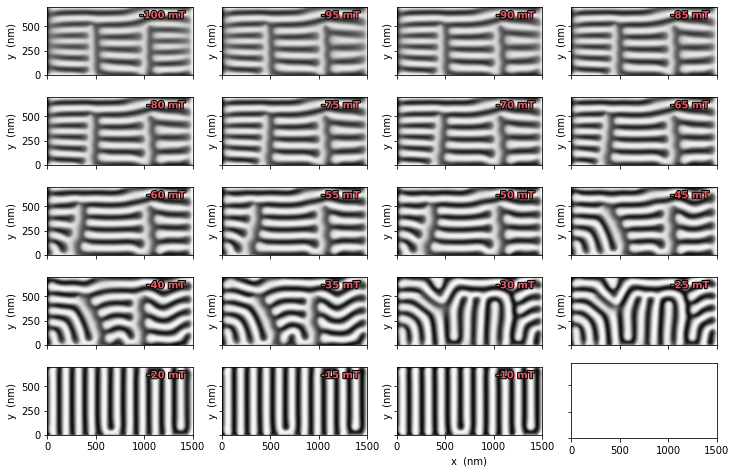

In [81]:
# for ku in ANIS_VALUES:

#     f, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5, sharex=True, sharey=True)

#     mz_av_anis_pick = {str(d.By): d.mz_average for d in mz_averages_sep if d.Ku == ku and d.sweep == 'down'}
#     mz_av_anis_pick['-100'] = [d.mz_average for d in mz_averages_sep if 
#                                d.By == -100 and d.Ku == ku and d.sweep == 'up'][0]
    
#     # Save this data
#     np.savez(PLOTDIR / f'mz_averages_Bzs_ku_{ku}_SWEEP-DOWN', **mz_av_anis_pick)

#     for b, by in enumerate(np.arange(-100, -9, 5)):

#         ax = axs.flat[b]
#         ax.imshow(mz_av_anis_pick[str(by)], cmap='Greys', **im_tubes_args)
#         # axs[b][p].set_xlabel('x  (nm)')
#         # axs[b][p].set_ylabel('y  (nm)')
#         # axs[b][p].set_title(f'Field: {by} mT')

#         t = ax.text(0.95, 0.95, f'{by} mT', ha='right', va='top',
#                     transform=ax.transAxes, 
#                     rotation=0, color='#EB5660', fontweight='bold')

#         t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
#         ax.set_ylabel('y  (nm)')

#         if b >= 18:
#             ax.set_xlabel('x  (nm)')

#     # plt.tight_layout()
#     plt.savefig(PLOTDIR / f'mz_average_Ku_{ku}_kJm3_field-relax_SWEEP_DOWN.png', dpi=200, bbox_inches='tight')
#     plt.show()

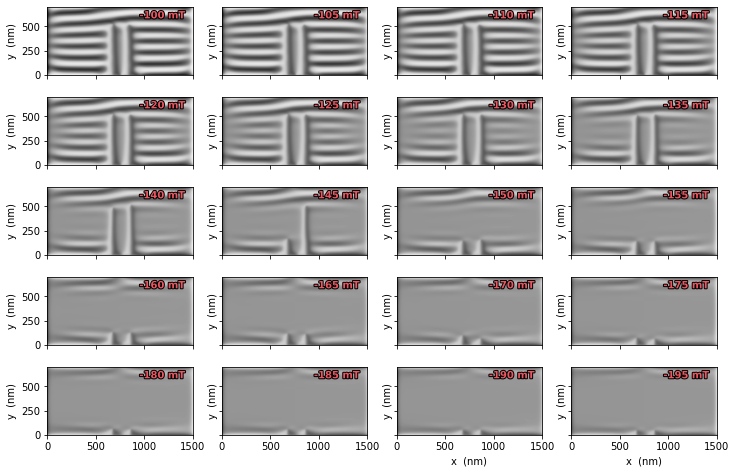

In [95]:
for ku in ANIS_VALUES:

    f, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5, sharex=True, sharey=True)

    mz_av_anis_pick = {str(d.By): d.mz_average for d in mz_averages_sep 
                       if d.Ku == ku and d.sweep == 'up'}
    
     # Save this data
    np.savez(PLOTDIR / f'mz_averages_Bzs_ku_{ku}_SWEEP-UP', **mz_av_anis_pick)

    for b, by in enumerate(np.arange(-100, -200, -5)):

        ax = axs.flat[b]
        ax.imshow(mz_av_anis_pick[str(by)], cmap='Greys', **im_tubes_args)
        # axs[b][p].set_xlabel('x  (nm)')
        # axs[b][p].set_ylabel('y  (nm)')
        # axs[b][p].set_title(f'Field: {by} mT')

        t = ax.text(0.95, 0.95, f'{by} mT', ha='right', va='top',
                    transform=ax.transAxes, 
                    rotation=0, color='#EB5660', fontweight='bold')

        t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
        ax.set_ylabel('y  (nm)')

        if b >= 18:
            ax.set_xlabel('x  (nm)')

    # plt.tight_layout()
    plt.savefig(PLOTDIR / f'mz_average_Ku_{ku}_kJm3_field-relax_SWEEP_UP.png', dpi=200, bbox_inches='tight')
    plt.show()